# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
import seaborn as sns
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, confusion_matrix
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
age                45222 non-null int64
workclass          45222 non-null object
education_level    45222 non-null object
education-num      45222 non-null float64
marital-status     45222 non-null object
occupation         45222 non-null object
relationship       45222 non-null object
race               45222 non-null object
sex                45222 non-null object
capital-gain       45222 non-null float64
capital-loss       45222 non-null float64
hours-per-week     45222 non-null float64
native-country     45222 non-null object
income             45222 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


In [4]:
data['income'].unique()

array(['<=50K', '>50K'], dtype=object)

### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

** HINT: ** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [5]:
# TODO: Total number of records
n_records = len(data)

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = len(data['income'][data['income']=='>50K'])

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = len(data['income'][data['income']=='<=50K'])

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k * 100/n_records

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {0:.2f}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


In [6]:
data.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [7]:
numerical_columns = data.describe().columns
numerical_columns

Index(['age', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')

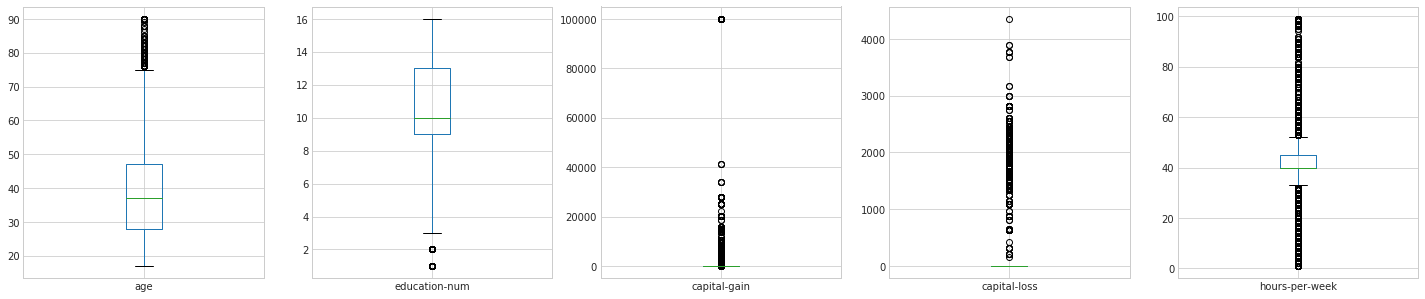

In [8]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_style("whitegrid")
plt.figure(figsize=(25,5))
for i,col in enumerate(numerical_columns):
    plt.subplot(1, len(numerical_columns), i+1)
    data[[col]].boxplot(fontsize=10)

In [9]:
def describe_categorical_values(df, non_interesting_columns=[], num_categories=5):
    values_df = pd.DataFrame()
    for i, column in enumerate(df.columns):
        if column in non_interesting_columns:
            continue
        top_values0 = ["{}: {}%".format(x,int(round(100*y/len(df))))
                       for x, y in zip(df[column].value_counts(dropna=False).head(num_categories).index,
                                       df[column].value_counts(dropna=False).head(num_categories).values)]
        if len(top_values0) < num_categories:
            top_values = [None]*num_categories
            top_values[:len(top_values0)] = top_values0
        else:
            top_values = top_values0
        values_df[column] = top_values
    return values_df.transpose()

describe_categorical_values(data, non_interesting_columns=numerical_columns, num_categories=8)

,0,1,2,3,4,5,6,7
workclass,Private: 74%,Self-emp-not-inc: 8%,Local-gov: 7%,State-gov: 4%,Self-emp-inc: 4%,Federal-gov: 3%,Without-pay: 0%,None
education_level,HS-grad: 33%,Some-college: 22%,Bachelors: 17%,Masters: 6%,Assoc-voc: 4%,11th: 4%,Assoc-acdm: 3%,10th: 3%
marital-status,Married-civ-spouse: 47%,Never-married: 32%,Divorced: 14%,Separated: 3%,Widowed: 3%,Married-spouse-absent: 1%,Married-AF-spouse: 0%,None
occupation,Craft-repair: 13%,Prof-specialty: 13%,Exec-managerial: 13%,Adm-clerical: 12%,Sales: 12%,Other-service: 11%,Machine-op-inspct: 7%,Transport-moving: 5%
relationship,Husband: 41%,Not-in-family: 26%,Own-child: 15%,Unmarried: 11%,Wife: 5%,Other-relative: 3%,None,None
race,White: 86%,Black: 9%,Asian-Pac-Islander: 3%,Amer-Indian-Eskimo: 1%,Other: 1%,None,None,None
sex,Male: 68%,Female: 32%,None,None,None,None,None,None
native-country,United-States: 91%,Mexico: 2%,Philippines: 1%,Germany: 0%,Puerto-Rico: 0%,Canada: 0%,El-Salvador: 0%,India: 0%
income,<=50K: 75%,>50K: 25%,None,None,None,None,None,None


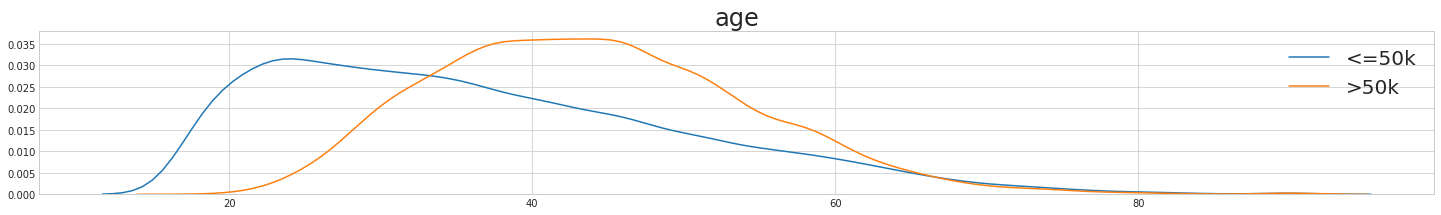

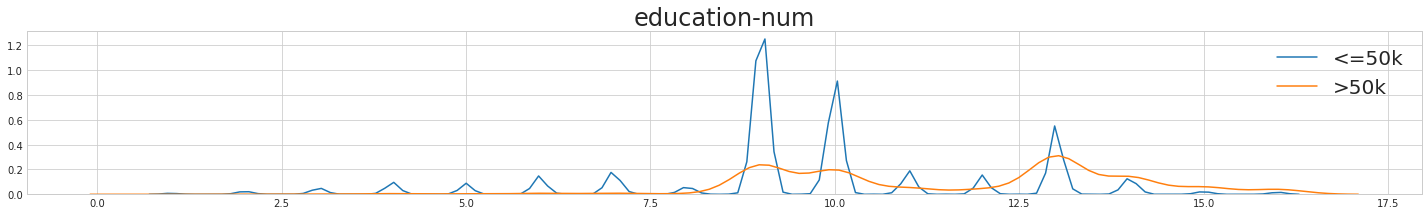

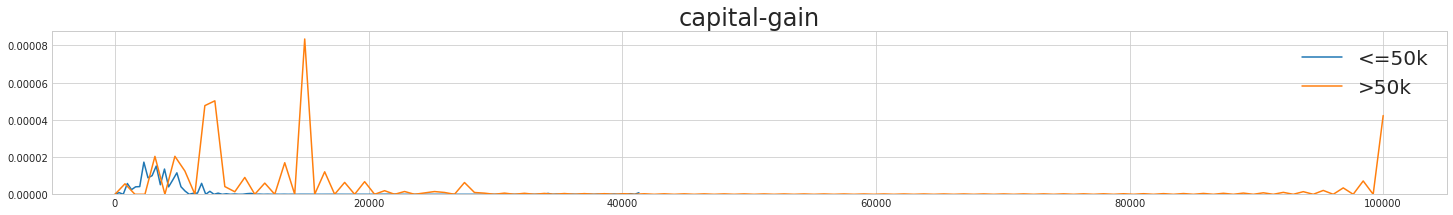

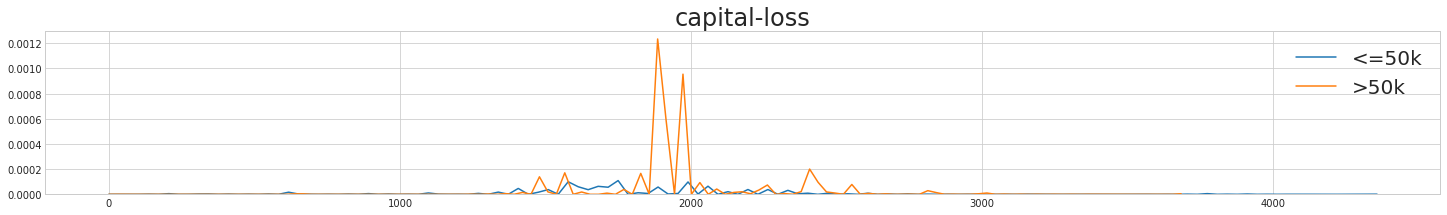

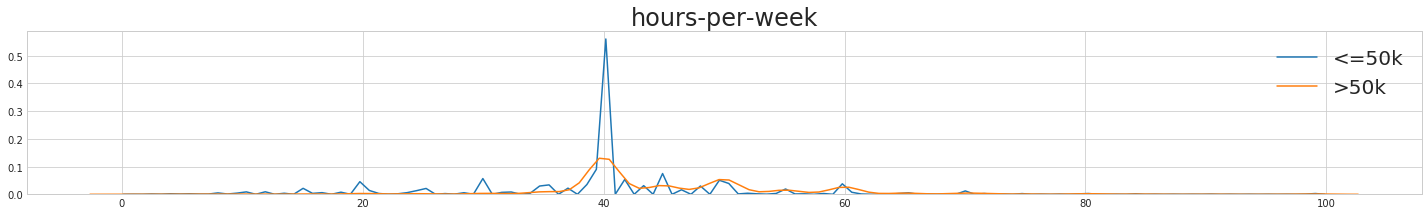

In [10]:
for col in numerical_columns:
    plt.figure(figsize=(25,3))
    sns.kdeplot(data.loc[data['income']=='<=50K', col], label='<=50k')
    sns.kdeplot(data.loc[data['income']=='>50K', col], label='>50k')
    plt.legend(fontsize=20)
    plt.title(col, fontsize=24)

In [11]:
def get_most_correlated_variables(corr, num_pairs=10):
    correlation_melted = pd.melt(corr.reset_index().rename(columns={"index": "var_1"}), id_vars=("var_1"),var_name='var_2')
    correlation_melted = correlation_melted[correlation_melted.var_1!=correlation_melted.var_2]
    correlation_melted['var_couple'] = correlation_melted[['var_1','var_2']].apply(lambda x:tuple(sorted([x[0],x[1]])), axis=1)
    correlation_melted = correlation_melted.drop_duplicates(subset='var_couple').drop(['var_couple'],axis=1)
    correlation_melted['abs_value'] = correlation_melted['value'].abs().round(3)
    return correlation_melted.sort_values(by='abs_value').tail(num_pairs).drop('abs_value', axis=1).reset_index(drop=True)

def plot_correlation_matrix(X, features2):
    corr = X[features2].corr()
     # return the most correlated variables
    most_correlated_variables = get_most_correlated_variables(corr, num_pairs=10)
    max_correlation = 1.25*most_correlated_variables['value'].abs().max()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    ax.set_yticklabels(features2, fontsize=18)
    ax.set_xticklabels(features2, rotation='vertical', fontsize=18)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=max_correlation, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .8})
    return most_correlated_variables

** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

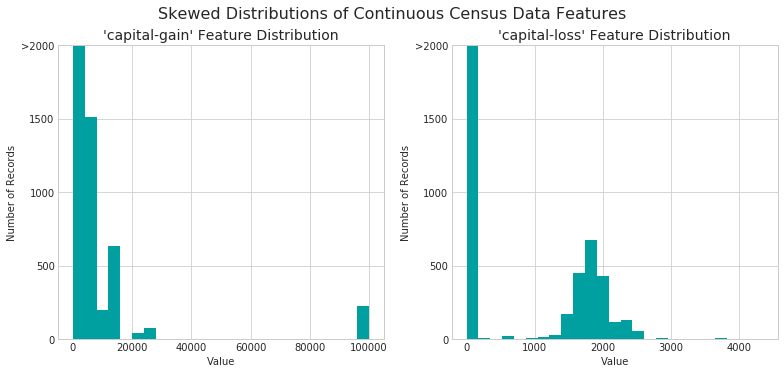

In [12]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

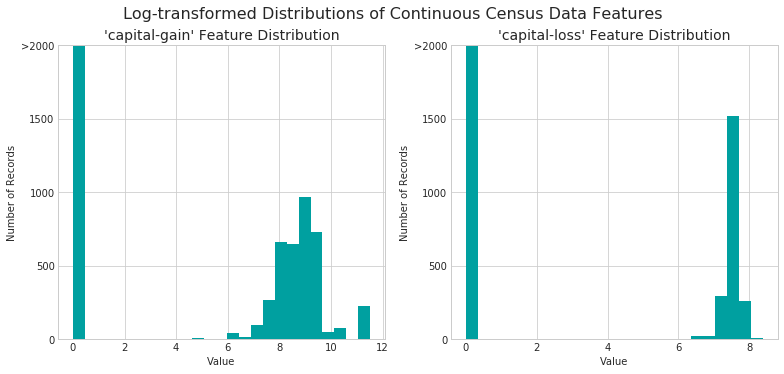

In [13]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

,var_1,var_2,value
0,education-num,age,0.037623
1,hours-per-week,capital-loss,0.051587
2,capital-loss,age,0.055331
3,capital-loss,capital-gain,-0.066899
4,capital-loss,education-num,0.078967
5,hours-per-week,capital-gain,0.086098
6,hours-per-week,age,0.101992
7,capital-gain,age,0.122068
8,capital-gain,education-num,0.129347
9,hours-per-week,education-num,0.146206


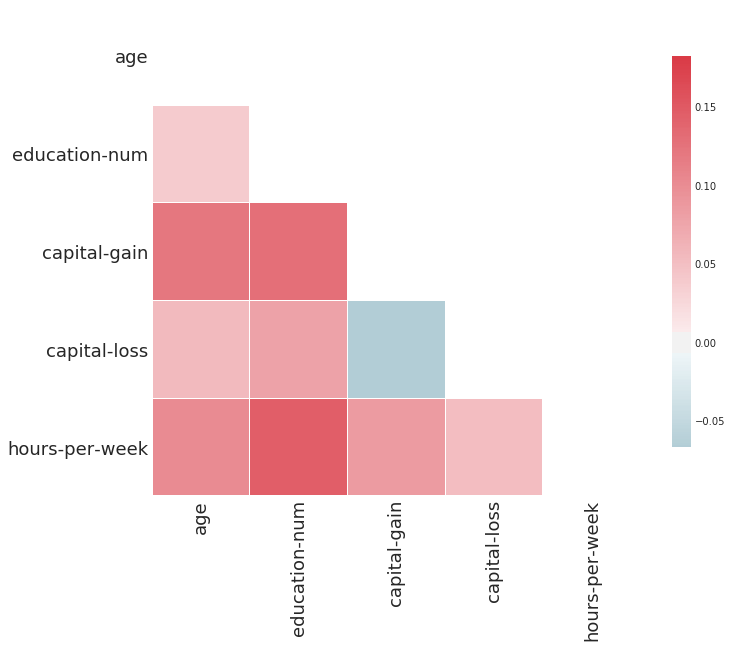

In [14]:
plot_correlation_matrix(features_raw, features_raw.columns.values)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [15]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'] # or user numerical_columns

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [16]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(['<=50K','>50K'])
le.transform(data.income)

array([0, 0, 0, ..., 0, 0, 1])

In [17]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# TODO: Encode the 'income_raw' data to numerical values
income = income_raw.map({'<=50K':0, '>50K':1})

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
print(encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

In [18]:
income[:10]

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    1
8    1
9    1
Name: income, dtype: int64

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [19]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [20]:
y_train[:10]

13181    0
10342    0
20881    0
24972    1
43867    0
4124     0
17641    0
17273    0
41191    0
5386     1
Name: income, dtype: int64

----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

** HINT: ** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [36]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# TODO: Calculate accuracy, precision and recall
TP = np.sum(income)
FP = income.count()
TN = 0
FN = 0

accuracy = greater_percent/100.0
recall = TP/(TP+FN)
precision = TP/(TP+FP)
beta = 0.5

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1 + np.square(beta)) * accuracy * recall / (np.square(beta) * accuracy + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


In [22]:
print(TP, FP, TN, FN, accuracy, recall, precision)

11208 45222 0 0 0.2478439697492371 1.0 0.198617756512


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

** HINT: **

Structure your answer in the same format as above^, with 4 parts for each of the three models you pick. Please include references with your answer.

**Answer: **

Model 1
Logistic regression classifier
 
	1. In almost every customer service\ success  logistic regression can use as churn prediction classifier that will help the customer service \ success team to contact customers that about to churn and try and "save" them before they do.
	2. Simple to understand and explain ; It seldom overfits ; Using L1 & L2 regularization is effective in feature selection; Fast to train ; Easy to train on big data thanks to its stochastic version, perform well when the data linearly separable
	3. You have to work hard to make it fit nonlinear functions ; Can suffer from outliers, perform poorly when the data is not linearly separable
	4. It seems that logistic regression is a good place to start and use as a baseline for the other model, due to the fact it is easy to understand and explain, it's fast and although I'm not sure the data is linearly separable it's seems that with hyperparameters tuning and some good preprocessing work we can generate and explore the model results easily and if I will find that the data is not linearly separable I will use SVM which will be my next option . 
	 
 
Model 2
Support Vector Machines (SVM)
	 
	1. One common use of SVM is text classification, if you want to classify any kind of text like comments\tweets\blogs and more as negative or positive (and some kind of sentiment analysis).
	2. Can model complex, nonlinear relationships;  Robust to noise (because they maximize margins), will perform well on complex \ non linearly separable and not big datasets.
	3. The major downside of SVMs is that they can be painfully inefficient to train and difficult to interpret when applying nonlinear kernels. Can fail to predict correctly due to the curse of dimensionality.
	4. It seems that after using logistic regression as a start, SVM will be interesting to use next, although we have more than 10,000 samples, I've have a strong Machin that can deal with it. It's seems that our data has a bit noise in it like categories that not showing up a lot etc. also there is a chance that our data is not linearly separable so in this case SVM can deal with those problems
	
	 
Model 3
Ensemble Methods
 
	1. Basically ensemble methods can work and solve many practical problems because they actually taking few algorithm results into account and "vote" for the best score therefor when using ensemble methods we can use many algorithms together and combine their results to the best performance result. One use case can be face detection. 
	2. These algorithms handle very well high dimensional spaces as well as large number of training examples. They decrease variance (bagging), bias (boosting), or improve predictions (stacking). Ensemble methods have been very successful in setting record performance in industry and the community. And perform well in many cases.
	3. The downside is ensemble methods is that you need know well the different algorithms that you can use and also to know how to deal the hyperparameters in every case. If not used wisely can be slow and not scalable. 
	4. I think that from what I've learned during this chapter and what I've read for answering those questions, it seems that ensemble methods can use to solve a lot of problems and our problem is one of them. But if we use it we need to use it wisely, it can out preform many individual models, but when using ensemble methods we need to choose right our methods and hyperparameters and if we going to production to make sure that we actually need it, in terms of performance difference and results.
 
 
	 
	 
	http://www.dummies.com/programming/big-data/data-science/machine-learning-dummies-cheat-sheet/
	http://www.lauradhamilton.com/machine-learning-algorithm-cheat-sheet
	https://www.quora.com/What-are-the-advantages-of-different-classification-algorithms
    https://blog.statsbot.co/ensemble-learning-d1dcd548e936![image.png](attachment:image.png)
	 


### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [23]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta = 0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = 0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.


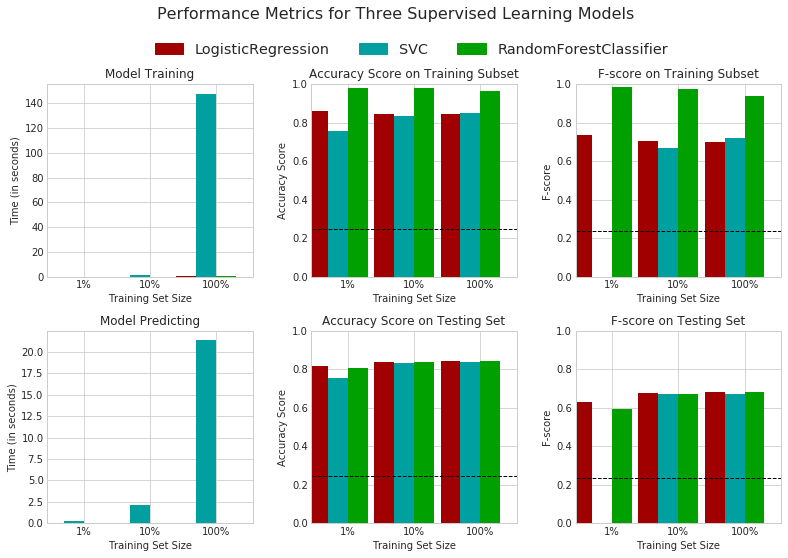

In [24]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# TODO: Initialize the three models
clf_A = LogisticRegression(random_state=1)
clf_B = SVC(random_state=1)
clf_C = RandomForestClassifier()

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(X_train)
samples_10 = int(0.1 * len(X_train))
samples_1 = int(0.01 * len(X_train))

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

** HINT: ** 
Look at the graph at the bottom left from the cell above(the visualization created by `vs.evaluate(results, accuracy, fscore)`) and check the F score for the testing set when 100% of the training set is used. Which model has the highest score? Your answer should include discussion of the:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

**Answer: **

I have conducted several evaluations on the data provided by you to identifity the most appropriate model for the task at hand of identifying the indviduals that make more than 50k a year. A general look at the data reveals that there are correlations between the feature vectors provided; level of education for example is correlated with workclass and occupation. This will make some of the features redundant.

Based on that 3 models where chosen: Logistic Regression(LR), Random Forests(RF), and SVM. These were evaluated against 3 metrics:

- The time needed to train the model and that to predict on 3 different sample sizes.
- The overall accuracy on the training and testing set on the 3 sample sizes.
- The F-score, biased towards precision then recalling since precision is more important in our case.

Before running the models, a simple naive predictor that predicts all as earning greater than 50k was assessed on the overall accuracy and precision, with a score of 0.24 and 0.29 respectively.

The SVM is very expensive computationally in both training and prediction time compared to the LR , without any gain in general accuracy or precision.

In the case of RF, though it runs considerably fast, it seems to be doing very good job on the training set but not as good on the testing with a small sample. This means that the RF is over fitting on lower sample. The RF gets better trained on larger samples(less variance or overfitting).

The logistic Regression runs the fastest, performs the best of the 3 with a small training sample.Logistic Regression supports as well online learning; learning on sequential data as it is recieved and updating to improve its accuracy.This is definitely a plus for the ML Charity.

Given the above, I would vote for the Logistic Regression, with fine tuning for the task at hand.

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

** HINT: **

When explaining your model, if using external resources please include all citations.

**Answer: ** 

Logistic Regression (LR) is a classification model, as a model to answer a yes / no question. In our case the question is: given what we know about the person, does he/she make more than 50k? For the LR to answer questions, it needs first to look at examples and learn from it. Based on that it istablishes a "model" to answer the same question of a new person given that we know about him/her the same peice of information as the people we trained our model on. In another words,by looking at the characteristics(what we call independent variables) we can deduce the answer of the target variable, or answer the yes/no question.

It is not enough to simply give the model data to train, and directly start predicting. We need to check how our model performs. for that we take our data and split it into training and testing set and evaluate the predicted answers of the model against what we know. This is the only way we can evaluate how good it is.

A picture is worth a thousand words (not true), so will explain how logistic Regression works. to simplify the problem imagine that we took one feature vector, which is hours worked. we scale the vector to be between 0 and 1, where close to 0 is the person who barely works (Peter, who inhereted his mom's company) and 1 is for those who work 48 hours a day. Say, hypothetically, that people who work more tend to earn more (again, not true, but lets assume that). From the data provided, the Logistic regression learns from the data, sending the high earner to the 1 and the low earners to the 0, and thus calibrates a logistic function accordinlgy. Of course, from the concocted diagram below, we notice a higher density of higher earners towards the more working hours (1 represents the higher earners, the above 50k and 0 the low earners, and most 50k), on the x axis.

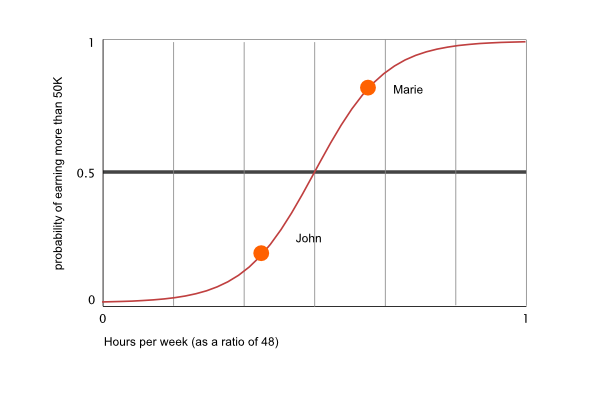

now we get new points, take below the example of Mari, the hard worker, and john the slacker. Their working hours ratio is pluged into the logistic function that was calibrated to get a value between 0 and 1. Marie, gets a vlue of say 0.8 and john say 0.24. 0.5 is the dividing line, so in this case, Marie would be sent to the 1 category of high earners and john down to 0 the low earners. This will identify if the person is a high earner or not.

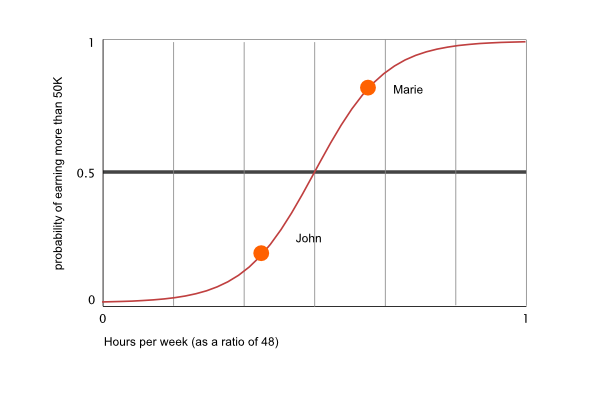

The interesting part is that Logistic Regression supports online learning, meaning that it can train as new data is streamed to out and calebarate to produce better predictions.

The predictions of the Logistic function in our case work pretty well. If we naively say that all of the data/people that we have info about have an income of more than 50k, we will get a correct answer 25% of the time, since this is roughly the percentage of people who earn more than 50k in the sample we have . With the predictor LR, we get a correct answer around 80% of the time; saying that this person is a high earner or he is not. Which is pretty good

A more accurate way to evaluate how good our model is is to identify how many of the "yes" is correct rather than looking at how correct is the "yes" and "no", since answering a yes means we will send the person a mail which would add to the cost. In the model, the "yes" is correct around 60% percent of the time

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [25]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Initialize the classifier
clf = LogisticRegression(random_state=1)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {"C":[0.01,0.1,0.25,0.5,0.75,10,50],"penalty":["l1","l2"]}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score,beta = 0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get best parameters
best_param = grid_fit.best_params_

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print ("best params:"+str(best_param))
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Unoptimized model
------
Accuracy score on testing data: 0.8419
F-score on testing data: 0.6832

Optimized Model
------
best params:{'C': 0.1, 'penalty': 'l2'}
Final accuracy score on the testing data: 0.8420
Final F-score on the testing data: 0.6842


### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  

**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |naive predictor benchmarks|
| :------------: | :---------------: | :-------------: | :-----------------------:|
| Accuracy Score |          0.8419   |       0.8420    |     0.1986               |
| F-score        |          0.6832   |       0.6842    |     0.2365               |


**Answer: **

 larger values of C gives more freedom to the model, smaller ones constrain the models. This along with the penalty method are hyperparams tuned to improve the generalizatioin of the model and avoid overfitting.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer:**

the most important features by order:

- Occupation
- Sex
- Age
- Race
- Native Country

Why:

- The Occupation tells us alot about the persons education, workclass,rough hours worked...
- It is a known phenomenon that men earn more than women in general around the world (the gab is much less in the scandanaivian countries).
- Age: since people who worked more should have more experience and thus higher salaries
- Race: again, numerious studies about racial differences in income even in the same country (skin color matters unfortunately).
- Native Country: people in developed countries are likely to have higher income
- The other features don't seem to be relative or can be deduced from these.

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

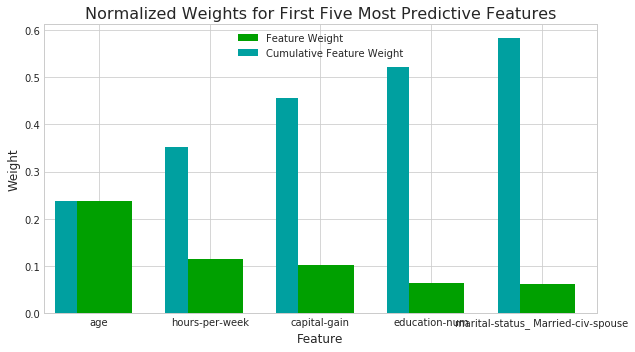

In [26]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import RandomForestClassifier

# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = RandomForestClassifier().fit(X_train, y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_ 

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**

Makes more sense. The older the person is the higher the income. Hours per week make the difference between a full-time and a part time, and probably people in executive positions tend to work more. Capital gain is an abvious one which I ignored in my ranking.

Marital status is interesting. In the late 1970s in the US, when the income was flat, more women started working which increased the household income (documentry : Inequality for All, Robert Reich). Marital status might define a stable "income" contributing partner.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [27]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8420
F-score on testing data: 0.6842

Final Model trained on reduced data
------
Accuracy on testing data: 0.8271
F-score on testing data: 0.6499


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer:**

The effect on the scores, both the F-score and accuracy, is not big. Since reduced features definitely reduces the complexity or dimensionality of the problem, as well reduce the runtime without considerable reduction in the performance, it is definitely a good idea to consider those features that matter the most and get rid of the redundancy. Further the support of online learning feature would help in "evolving" the logistic Regression.

## My playground 

In [28]:
%matplotlib inline
def find_best_threshold(thresholds, fpr, tpr):
    """
    find the best threshold from the roc curve. by finding the threshold for the point which is closest to (fpr=0,tpr=1)
    """
    fpr_tpr = pd.DataFrame({'thresholds': thresholds, 'fpr': fpr, 'tpr': tpr})
    fpr_tpr['dist'] = (fpr_tpr['fpr'])**2 + (fpr_tpr['tpr']-1)**2
    return fpr_tpr.ix[fpr_tpr.dist.idxmin(), 'thresholds']


def get_model_results(model, train, test, y_train, y_test):
    probabilities = model.predict_proba(test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    threshold = find_best_threshold(thresholds, fpr, tpr)
    predictions = probabilities>threshold
    plt.figure()
    plt.plot(fpr, tpr, label='test')
    roc_auc = roc_auc_score(y_test, probabilities)
    probabilities = model.predict_proba(train)[:,1]
    fpr, tpr, thresholds = roc_curve(y_train, probabilities)
    plt.plot(fpr, tpr, label='train')
    plt.plot([0, 1], [0, 1], 'r--', label='random guess')
    plt.title("area under the ROC curve = {}".format(roc_auc), fontsize=18);
    print(classification_report(y_test, predictions))
    plt.legend()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


             precision    recall  f1-score   support

          0       0.94      0.78      0.85      6840
          1       0.56      0.84      0.67      2205

avg / total       0.85      0.80      0.81      9045



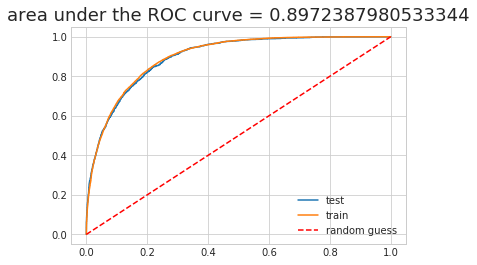

In [29]:
model = make_pipeline(MinMaxScaler(),LogisticRegression())
model.fit(X_train, y_train)
get_model_results(model, X_train, X_test, y_train, y_test)

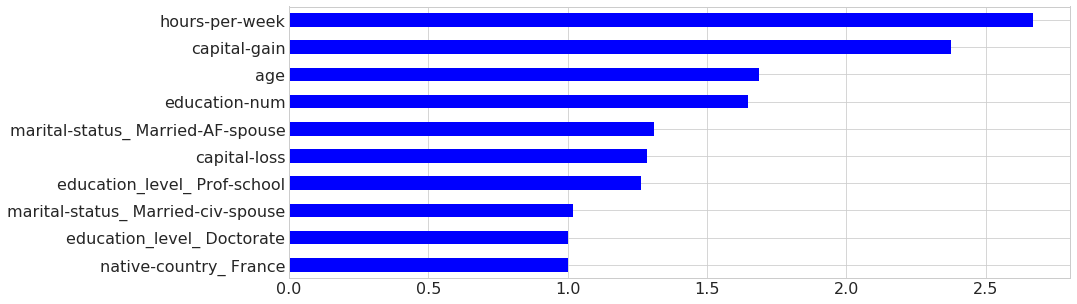

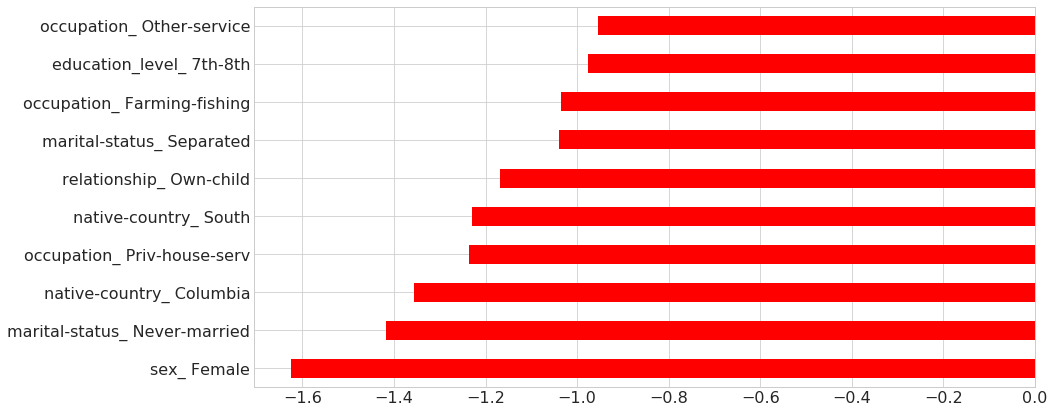

In [30]:
feature_importance = pd.Series(index=X_train.columns , data= model.named_steps['logisticregression'].coef_[0])
feature_importance = feature_importance.sort_values()
plt.figure(figsize=(14,5))
feature_importance.tail(10).plot.barh(fontsize=16,color='b' )
plt.figure(figsize=(14,5))
feature_importance.head(10).plot.barh(fontsize=16, figsize=(14,7), color='r')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


             precision    recall  f1-score   support

          0       0.93      0.79      0.86      6840
          1       0.56      0.81      0.66      2205

avg / total       0.84      0.80      0.81      9045



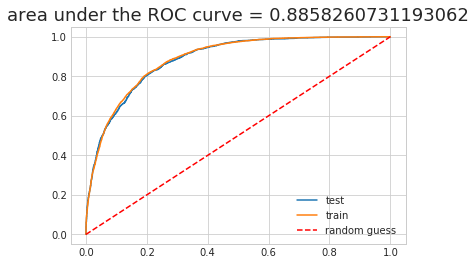

In [31]:
from sklearn.decomposition import PCA

model = make_pipeline(PCA(n_components=30,whiten=False),LogisticRegression())
model.fit(X_train, y_train)
get_model_results(model, X_train, X_test, y_train, y_test)

In [32]:
poly = PolynomialFeatures(2)
train_poly_features = poly.fit_transform(X_train[numerical_columns])
test_poly_features = poly.transform(X_test[numerical_columns])
train_with_poly_features = pd.concat([X_train.reset_index(drop=True),pd.DataFrame(train_poly_features)],axis=1)
test_with_poly_features = pd.concat([X_test.reset_index(drop=True),pd.DataFrame(test_poly_features)],axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


             precision    recall  f1-score   support

          0       0.94      0.82      0.88      6840
          1       0.60      0.82      0.70      2205

avg / total       0.85      0.82      0.83      9045



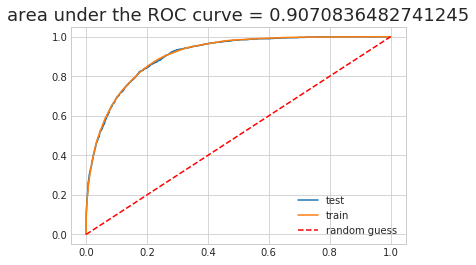

In [33]:
model = make_pipeline(MinMaxScaler(),LogisticRegression())
model.fit(train_with_poly_features, y_train)
get_model_results(model, train_with_poly_features, test_with_poly_features, y_train, y_test)

In [34]:
categorical_columns = [x for x in data.columns if x not in numerical_columns and x!='income']
categorical_columns

['workclass',
 'education_level',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

In [35]:
def remove_infrequent_values(df, categorical_columns, frequency_threshold=20):
    infrequent_cols_to_remove = []
    for cat_col in categorical_columns:
        col_count = df[cat_col].value_counts()
        infrequent_values = col_count[col_count<frequency_threshold].index.values
        if not col_count[col_count<20].empty:
            print("removing columns: \n{} \n".format(col_count[col_count<frequency_threshold]))
        infrequent_cols_to_remove += ["{}_{}".format(cat_col, x) for x in infrequent_values]
    return df

data_clean = remove_infrequent_values(data, categorical_columns)

removing columns: 
 Armed-Forces    14
Name: occupation, dtype: int64 

removing columns: 
 Honduras              19
 Hungary               18
 Holand-Netherlands     1
Name: native-country, dtype: int64 



> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.